In [1]:
library(tidyverse)
library(ggplot2)
library(patchwork)
source("helper.R")
library(scales)
library(data.table)
library(ggrepel)
my_theme = my_theme + theme(legend.key.size = unit(0.5, 'lines'))

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor



Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose




In [2]:
win_size = 1000000
chrom= "chr12"
prop_acc=0.4
data_path="../../output/greatapes-diversity-data/"
outpath="../../output/final_figs/"
f_prefix="long-cor"
neutral_cov_path="../../output/joined_stats/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_sample-size_10_joinedcovs.tsv"
dir.create(outpath, recursive=T)

Warning message in dir.create(outpath, recursive = T):
"'../../output/final_figs' already exists"


In [3]:
pidxy_csv_path = paste0(data_path,chrom,"/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv")

In [4]:
pidxy = fread(pidxy_csv_path, header =T)

In [5]:
p_rec = ggplot(pidxy, aes(x=start,y=mean_rec)) + geom_line() +
    labs(x="", y="Recombination rate") +
    xlim(0, 1.58e8) +
    my_theme
p_ex = ggplot(pidxy, aes(x=start,y=ex_overlap)) + geom_line() +
    labs(x="", y="% Exon") + 
    xlim(0, 1.58e8) +
    my_theme

In [36]:
land_rds_path = paste0(data_path,chrom,"/subset-",chrom,"-landscapes_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.rds")
land_rds = readRDS(land_rds_path)
#land_rds+ my_theme + labs(subtitle="", x="Position")


pdf(paste0(outpath,"pidxy-ex-rec-land_",chrom,"_data.pdf"), width = 6.5, height = 6.0)
(land_rds+ my_theme + labs(subtitle="", x="")) / (p_ex + p_rec)
#grid::grid.draw(grid::textGrob("Value", x = 0.05, rot = 90))
grid::grid.draw(grid::textGrob("Position", y = 0.02, x=0.54))
dev.off()
#ggsave(filename=paste0(outpath,"pidxy-land_",chrom,"_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

png 
  2

## Figure 3

In [7]:
rds_path = paste0(data_path,chrom,"/",f_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_all_prop-acc_",prop_acc, ".rds")
df = readRDS(rds_path)

In [8]:
# resorting the spp combos -- will be needed to join with the neutral cov
df$combo1 = apply(df, 1, function(x) paste(x["spp1_1"], x["spp2_1"], sep="_"))
df$combo2 = apply(df, 1, function(x) paste(x["spp1_2"], x["spp2_2"], sep="_"))
df[,c("combo1","combo2")] = t(apply(df,1, function(x) sort(unlist(x[c("combo1", "combo2")]))))

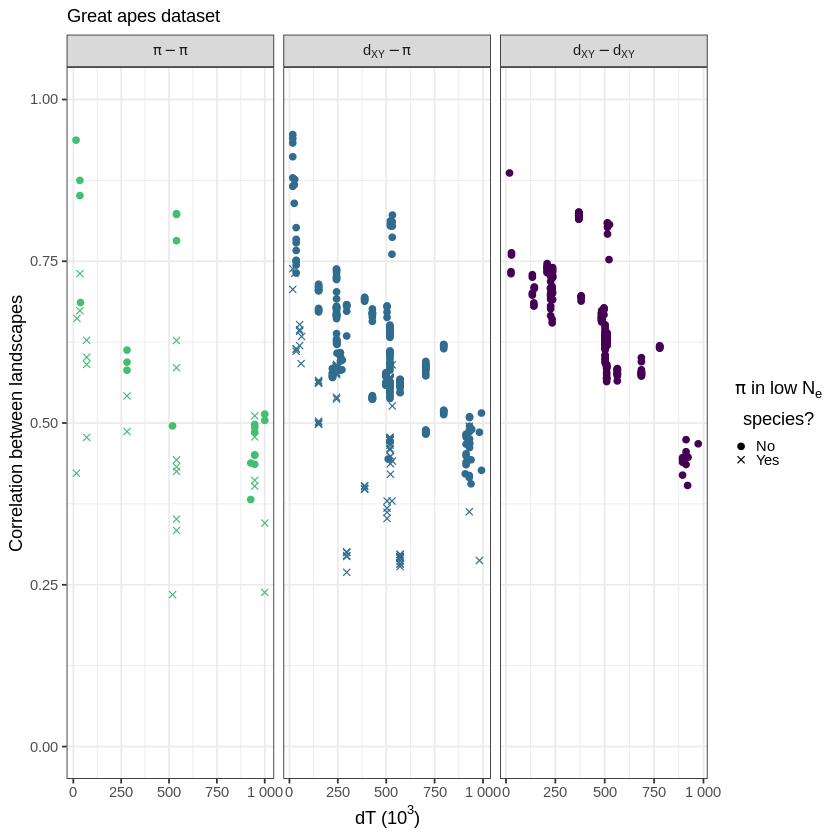

In [9]:
corr_dt_panel = function(df,subt="", x_colname="dt", end=0.7, dxydxylab="d[XY]-d[XY]") {
    statcombolabs = c(`dxy_dxy`=dxydxylab, `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
    lownelabs = c(`TRUE`="Yes", `False`="No")
    p_dt = ggplot(df[df$has_shared == FALSE,], aes_string(y="value", x=x_colname, label="stat_combo1", label2="stat_combo2", shape="lowne", col="statcombo")) + 
        geom_point() +
        scale_shape_manual(values=c(19, 4), labels=c("No", "Yes")) +
        scale_x_continuous(labels = label_number(scale = 1e-3)) +
        scale_color_viridis_d(direction=1, end=end) +
        facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
        labs(x=bquote("dT ("*10^3*")"), y="Correlation between landscapes", shape=bquote(atop(pi*" in low "*N[e], "species?")),
            subtitle=subt) +
        ylim(0,1) +
        guides(shape = guide_legend(title.position="top"), color=FALSE)+
        my_theme
    return(p_dt)
}
corr_dt_panel(df, subt="Great apes dataset")
ggsave(filename=paste0(outpath,"cor-pidxy-dT_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

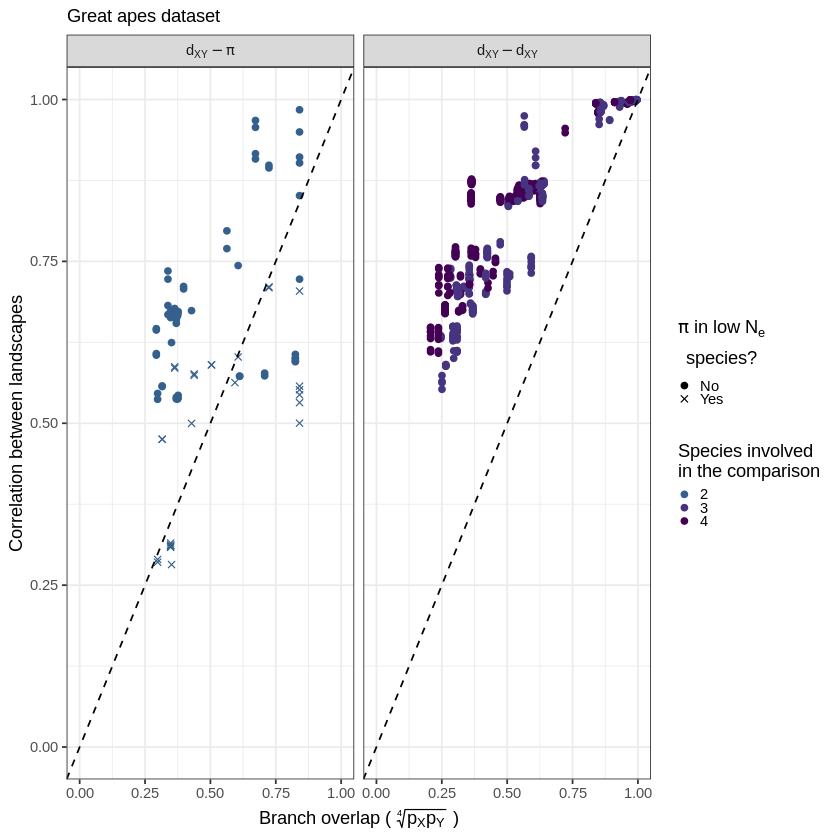

In [10]:
corr_panel = function(df,subt="", x_colname="sqsqpxpy", x_name=bquote("Branch overlap ("~sqrt(p[X]*p[Y],4)~")"), has_shared=TRUE, end=0.7) {
    #df$num_spp = as.character(df$num_spp)
    statcombolabs = c(`dxy_dxy`="d[XY]-d[XY]", `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
    lownelabs = c(`TRUE`="Yes", `False`="No")
    p_bo = ggplot(df[df$has_shared == has_shared,], aes(y=value, x=get(x_colname), label=stat_combo1, label2=stat_combo2, shape=lowne, col=factor(num_spp))) + 
        geom_point() +
        scale_shape_manual(values=c(19, 4), labels=c("No", "Yes")) +
        scale_color_viridis_d(direction=-1,begin=0., end=end) +
        facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
        labs(x=x_name, y="Correlation between landscapes", shape=bquote(atop(pi*" in low "*N[e], "species?")), 
             col="Species involved\nin the comparison", subtitle=subt) +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
        xlim(0.0,1.0) +
        ylim(0.0,1.0)+
        guides(colour = guide_legend(title.position="top"), shape = guide_legend(title.position="top")) +
        my_theme
    return(p_bo)
}
corr_panel(df, subt="Great apes dataset", end=0.3)
ggsave(filename=paste0(outpath,"cor-pidxy-branchoverlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

In [11]:
# reading in neutral sim covariances
neutral_covs = read.table(neutral_cov_path, header=TRUE)
neutral_covs = neutral_covs %>%
  mutate(across(spp1_1:spp2_2, ~sub("gorila", "gorilla", .)))
neutral_covs[,c("spp1_1","spp2_1")] = t(apply(neutral_covs,1, function(x) sort(x[c("spp1_1", "spp2_1")])))
neutral_covs[,c("spp1_2","spp2_2")] = t(apply(neutral_covs,1, function(x) sort(x[c("spp1_2", "spp2_2")])))
neutral_covs$combo1 = apply(neutral_covs, 1, function(x) paste(x["spp1_1"], x["spp2_1"], sep="_"))
neutral_covs$combo2 = apply(neutral_covs, 1, function(x) paste(x["spp1_2"], x["spp2_2"], sep="_"))
neutral_covs[,c("combo1","combo2")] = t(apply(neutral_covs,1, function(x) sort(x[c("combo1", "combo2")])))
#neutral_covs

neutral_covs$corr = NA

for (i in 1:nrow(neutral_covs)) {
    # corr is cov/sqrt(var1*var2)
    # sd = cov(a,a)
    row_var_1 = (neutral_covs[,"combo1"] == neutral_covs[i,"combo1"]) & 
        (neutral_covs[,"combo2"] == neutral_covs[i,"combo1"]) 
    row_var_2 = (neutral_covs[,"combo1"] == neutral_covs[i,"combo2"]) & 
        (neutral_covs[,"combo2"] == neutral_covs[i,"combo2"]) 
    norm = sqrt(neutral_covs[row_var_1,"cov"])*sqrt(neutral_covs[row_var_2,"cov"])
    #print(norm)
    neutral_covs[i,"corr"] = neutral_covs[i,"cov"] / norm
}

In [12]:
df = left_join(x=df, y=neutral_covs[,c("corr","combo1","combo2")])

Joining, by = c("combo1", "combo2")



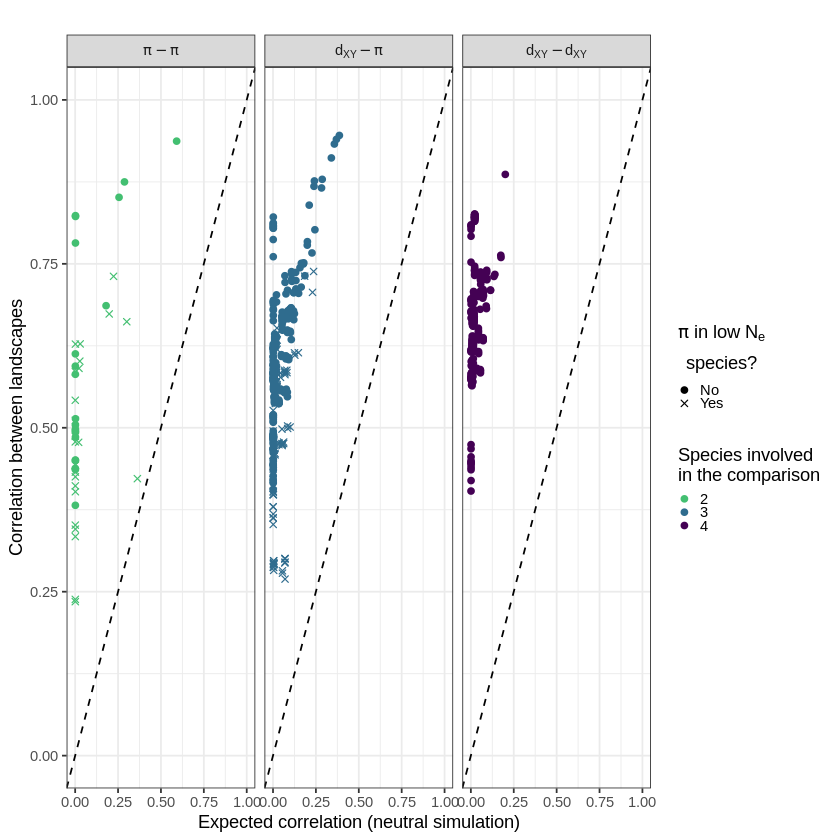

In [13]:
corr_panel(df,subt="", x_colname="corr", x_name="Expected correlation (neutral simulation)", has_shared=FALSE)
ggsave(filename=paste0(outpath,"cor-pidxy-corrneut-nooverlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

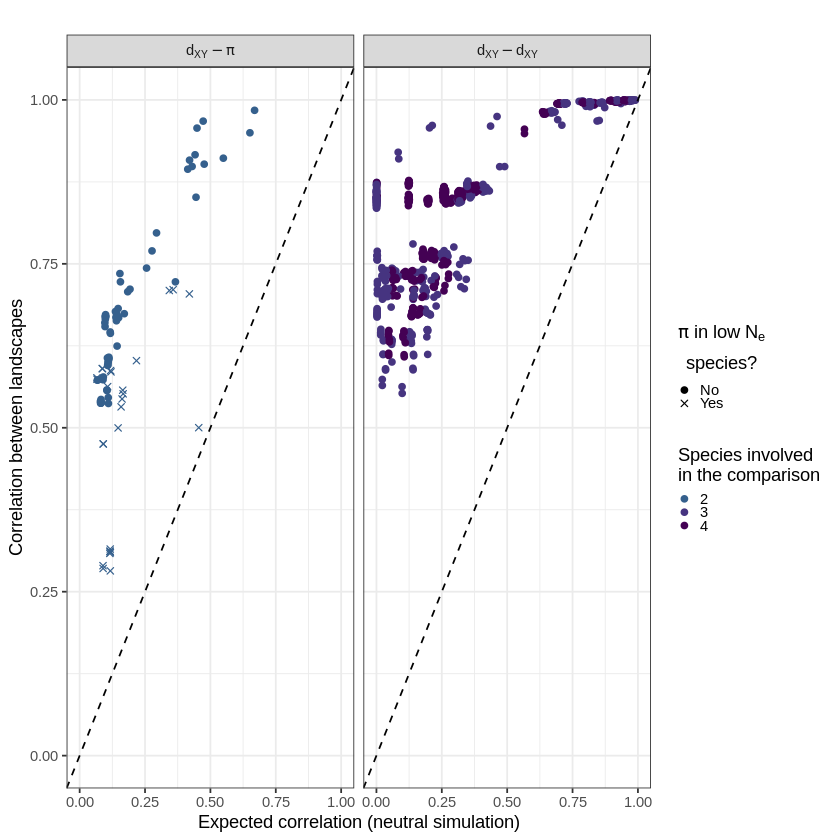

In [14]:
corr_panel(df,subt="", x_colname="corr", x_name="Expected correlation (neutral simulation)", has_shared=TRUE, end=0.3)

ggsave(filename=paste0(outpath,"cor-pidxy-corrneut-overlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

In [15]:
rds_path_neutral = "../../output/sims_results/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10/long-cor_sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4.rds"
neudf = readRDS(rds_path_neutral)
neudf$label = round(neudf$value,2)
neudf[(neudf$stat_combo1=="pi_central-chimp" & neudf$stat_combo2=="pi_eastern-chimp") |
      (neudf$stat_combo2=="pi_bornean-orangutan" & neudf$stat_combo1=="dxy_central-chimp western-chimp"),]
p_neut_corr_dt_panel = corr_dt_panel(neudf, subt="Neutral simulation")+ylim(-0.25,1)+geom_abline(intercept = 0, slope = 0, linetype = "dashed") +
                        geom_text_repel(data = neudf[(neudf$stat_combo1=="pi_central-chimp" & neudf$stat_combo2=="pi_eastern-chimp") |
      (neudf$stat_combo2=="pi_bornean-orangutan" & neudf$stat_combo1=="dxy_central-chimp western-chimp"),],
                                        aes(label = label))
ggsave(filename=paste0(outpath,"cor-pidxy-dT_neutral.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

,stat_combo1,stat_combo2,value,mrca1,stat1,spp1_1,spp2_1,mrca2,stat2,spp1_2,⋯,denom_px,denom_py,px,py,sqsqpxpy,lowne,num_spp,has_shared,harmne,label
,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<lgl>,<dbl>,<dbl>
53,dxy_central-chimp western-chimp,pi_bornean-orangutan,0.2386553,chimps,dxy,central-chimp,western-chimp,bornean-orangutan,pi,bornean-orangutan,⋯,34240,18654,0,0,0,FALSE,3,FALSE,NA,0.24
1485,pi_central-chimp,pi_eastern-chimp,0.6180284,central-chimp,pi,central-chimp,central-chimp,eastern-chimp,pi,eastern-chimp,⋯,7000,7000,0,0,0,FALSE,2,FALSE,NA,0.62


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



In [16]:
table(c("A","T","C"), c("G","G","A"))

   
    A G
  A 0 1
  C 1 0
  T 0 1

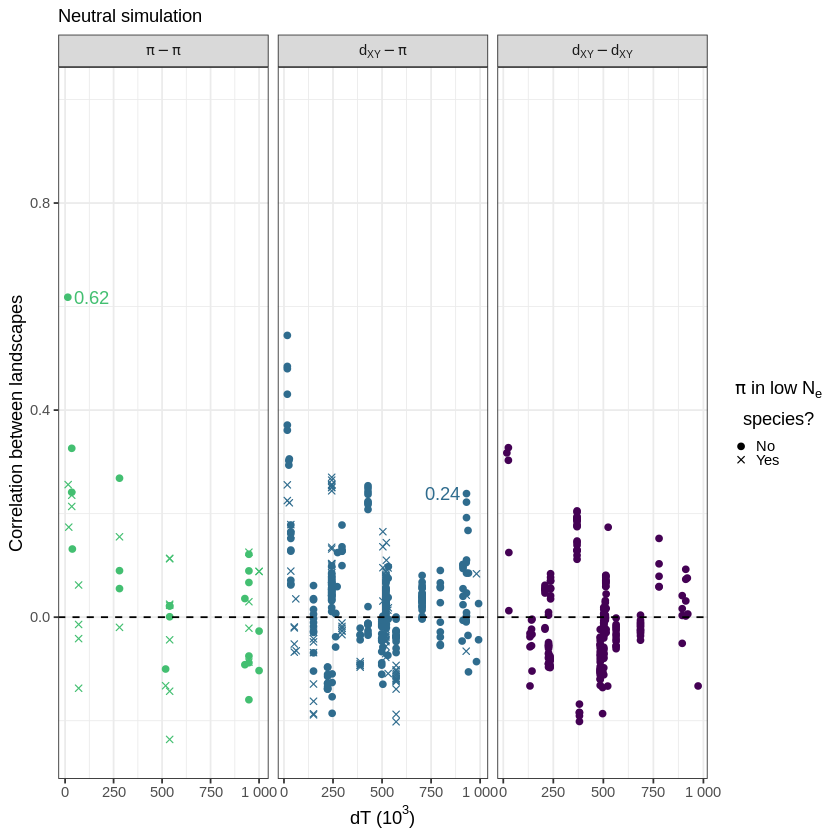

In [17]:
p_neut_corr_dt_panel

In [18]:
neudf$label = round(neudf$value,2)
neudf[(neudf$stat_combo1=="pi_central-chimp" & neudf$stat_combo2=="pi_eastern-chimp") |
      (neudf$stat_combo2=="pi_bornean-orangutan" & neudf$stat_combo1=="dxy_central-chimp western-chimp"),]

,stat_combo1,stat_combo2,value,mrca1,stat1,spp1_1,spp2_1,mrca2,stat2,spp1_2,⋯,denom_px,denom_py,px,py,sqsqpxpy,lowne,num_spp,has_shared,harmne,label
,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<lgl>,<dbl>,<dbl>
53,dxy_central-chimp western-chimp,pi_bornean-orangutan,0.2386553,chimps,dxy,central-chimp,western-chimp,bornean-orangutan,pi,bornean-orangutan,⋯,34240,18654,0,0,0,FALSE,3,FALSE,NA,0.24
1485,pi_central-chimp,pi_eastern-chimp,0.6180284,central-chimp,pi,central-chimp,central-chimp,eastern-chimp,pi,eastern-chimp,⋯,7000,7000,0,0,0,FALSE,2,FALSE,NA,0.62


In [19]:
neut_land_rds_path = "../../output/sims_results/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10/figs/subset-chr12-landscapes_sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4.rds"
neut_land_rds = readRDS(neut_land_rds_path)
p_neut_land = neut_land_rds+ my_theme + labs(subtitle="", x="Position")
ggsave(filename=paste0(outpath,"pidxy-land-",chrom,"_neutral.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

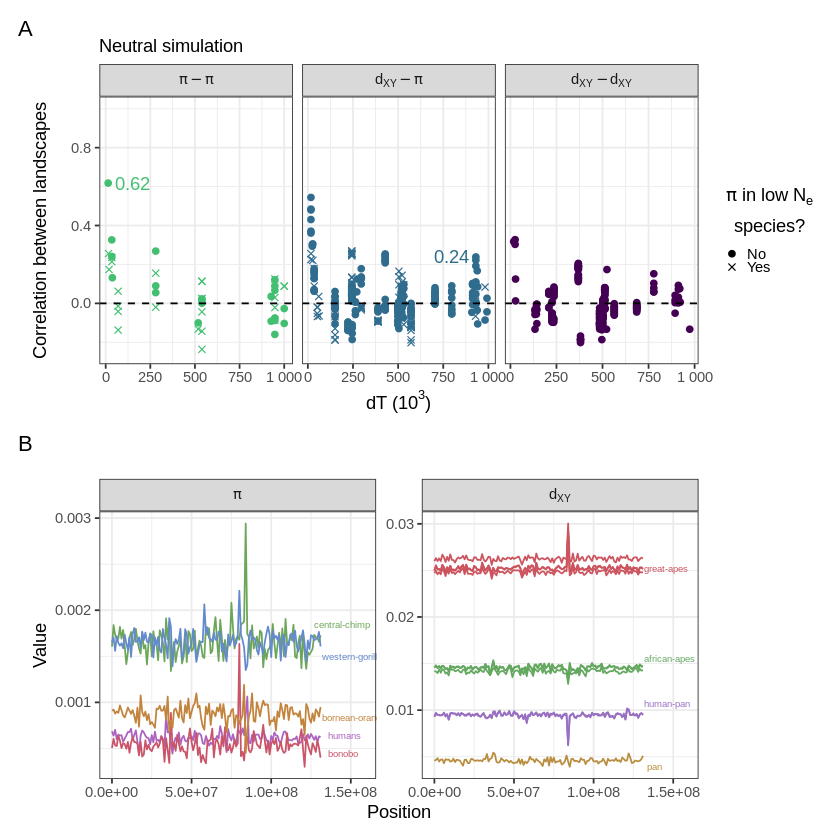

In [20]:
wrap_plots(list(p_neut_corr_dt_panel,p_neut_land), nrow=2) + plot_annotation(tag_levels = 'A')
ggsave(filename=paste0(outpath,"pidxy-corr-land-panel_neutral.pdf"), width = 6.5, height = 6, units = "in", dpi=300)

In [21]:
csv_path_ex_correls = "../../output/greatapes-diversity-data/cor-pidxy-exon_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv"

ex_corr = read.table(csv_path_ex_correls, sep="\t", header=T, quote="")


In [22]:
plot_annot_corr = function(df,ylims, annot="% Exon") {
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
    annot_pi_corr = ggplot(df[df$spp1==df$spp2,], aes(y=estimate, x="", shape=zlowne, col=spp1)) + #sprintf("\u03c0")
        geom_point() + 
        my_theme + 
        scale_colour_manual(values=pal10col) +
        xlab("") +
        labs(shape=bquote("Includes low "*N[e]*" species?"),col="Species", y=bquote("Corr("~pi~","~.(annot)~")"))+
        scale_shape_discrete(labels=lownelabs)+
        ylim(ylims)# + theme(legend.position = 'top')
    annot_dxy_corr = ggplot(df[df$spp1!=df$spp2,], aes(y=estimate, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Corr("~d[XY]~","~.(annot)~")"))+
        xlab(bquote(T[MRCA]~"("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims)#+ theme(legend.position = 'bottom')
    p = wrap_plots(annot_pi_corr, annot_dxy_corr, guides="collect", widths=c(1,4))# & theme(legend.position = 'bottom')
    return(list(annot_pi_corr, annot_dxy_corr))

}

In [23]:
p1s=plot_annot_corr(ex_corr, c(-0.6,-0.15), "% Exon")
#ggsave(filename=paste0(outpath,"cor-pidxy-ex_data.pdf"), width = 6.5, height = 3, scale=1.5, units = "in", dpi=300)

In [24]:
csv_path_rec_correls = "../../output/greatapes-diversity-data/cor-pidxy-rec-rate_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv"

rec_corr = read.table(csv_path_rec_correls, sep="\t", header=T, quote="")
p2s=plot_annot_corr(rec_corr, c(0.1, 0.45), "Recombination rate")
#ggsave(filename=paste0(outpath,"cor-pidxy-rec_data.pdf"), width = 6.5, height = 3, scale=1.5, units = "in", dpi=300)

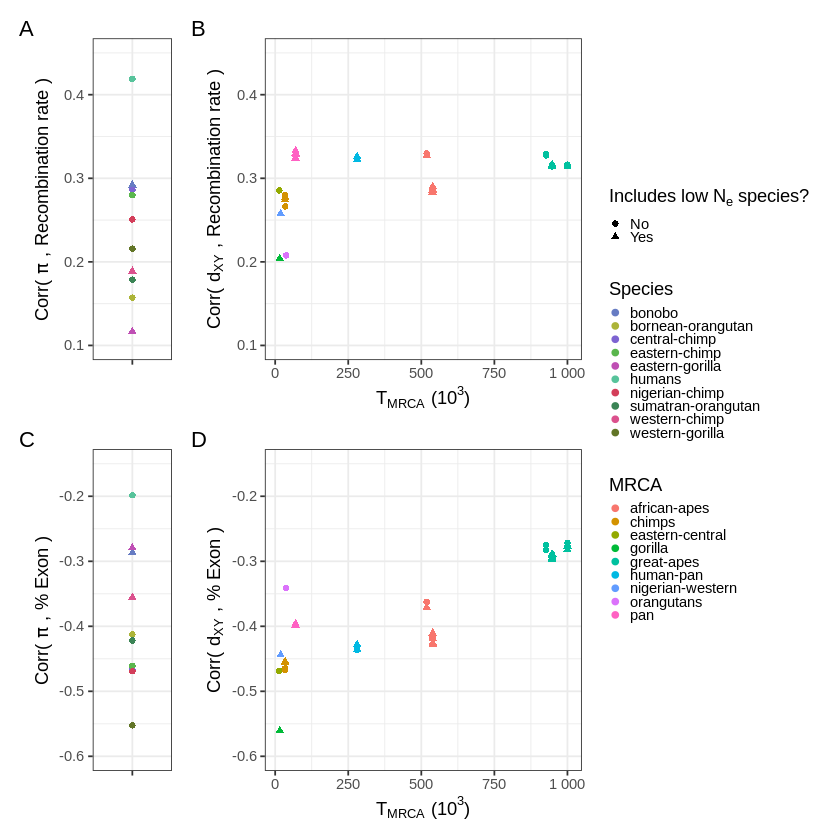

In [25]:
wrap_plots(c(p2s,p1s), widths=c(1,4), nrow=2, guides="collect")+
  plot_annotation(tag_levels = 'A')

In [26]:
ggsave(filename=paste0(outpath,"cor-pidxy-annot_data.pdf"), width = 6.5, height = 6, scale=1.25, units = "in", dpi=300)

In [27]:
plot_dxy_land = function(df, label) {
    statlabs = c(`dxy`=label, `pi`="pi")
    subchr="chr12"
    spp_subset=c("humans", "bonobo", "bornean-orangutan", "western-gorilla", "central-chimp")
    col5pal = c("#ab62c0","#6ca659","#ca556a","#648ace","#c2843c")
    col4pal = c("#b98d3e","#9970c1","#64a860","#cc545e")
    subpidxy = df[chr==subchr & spp1 %in% spp_subset & spp2 %in% spp_subset & stat=="dxy"]
    subpidxy = subpidxy %>%
      mutate(label = if_else(start == max(start) & value, as.character(mrca), NA_character_))
    subpidxy$label[duplicated(subpidxy$label)] = NA_character_

    p_land = ggplot(data = subpidxy, aes(x=start, y=value, group=combo)) +
                geom_point(aes(col=mrca), alpha=0.2, size=0.5)+
                geom_smooth(aes(col=mrca), span=1/4, se=FALSE,size=0.75) +
                facet_wrap(.~factor(stat, levels=c("pi", "dxy")), scales="free", labeller=as_labeller(statlabs, default=label_parsed)) +
                scale_colour_manual(values=c(col5pal,col4pal)) +
                labs(y="Value", x="", col="") +
                theme(legend.margin=margin(t=0, r=0, b=0, l=0, unit="cm"), legend.position="bottom", legend.box="vertical") +
                guides(colour = guide_legend(nrow = 2, byrow=TRUE)) +
                geom_text_repel(aes(label = label, col=mrca),
                      nudge_x = 1,
                      na.rm = TRUE, force_pull=3.2, xlim=c(1.28e8,NA), size=2) +
                xlim(0, 1.58e8) + guides(color=FALSE) +
                my_theme
    return(p_land)
}


In [28]:
pidxy_path_wwss = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_WWSS_prop-acc_0.4.tsv"


pidxy_wwss = fread(pidxy_path_wwss, header =T)

label = "d[XY]*' for W-W or S-S mutations'"
p_wwss = plot_dxy_land(pidxy_wwss, label)

In [29]:
pidxy_path_ws = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_WS_prop-acc_0.4.tsv"

pidxy_ws = fread(pidxy_path_ws, header =T)

label = "d[XY]*' for W-S mutations'"
p_ws = plot_dxy_land(pidxy_ws, label)

In [30]:
pdf(paste0(outpath,"partitioned_dxy_landscapes_data.pdf"), width = 3.5, height = 6.0)
wrap_plots(p_wwss, p_ws, nrow=2) + plot_annotation(tag_levels = 'A')
#grid::grid.draw(grid::textGrob("Value", x = 0.05, rot = 90))
grid::grid.draw(grid::textGrob("Window", y = 0.04, x=0.58))
dev.off()

#ggsave(filename=paste0(outpath,"partitioned_dxy_landscapes_data.pdf"), width = 3.5, height = 6.0, units = "in", dpi=300)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



png 
  2

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



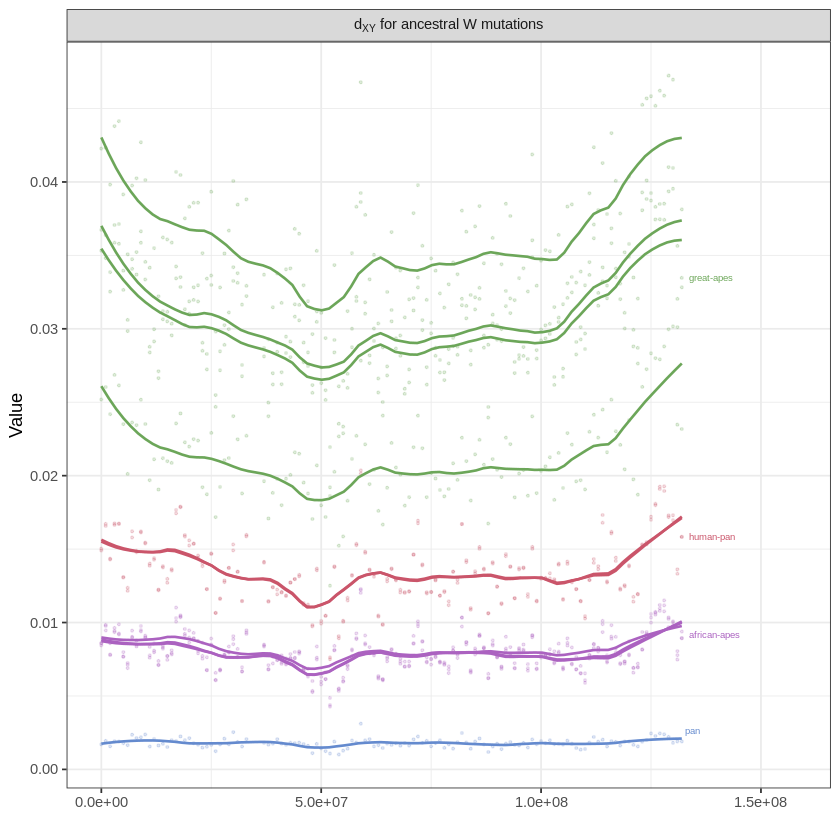

In [31]:
pidxy_path_at = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_A-T_curr_all_prop-acc_0.4.tsv"

pidxy_at = fread(pidxy_path_at, header =T)

label = "d[XY]*' for ancestral W mutations'"
p_at = plot_dxy_land(pidxy_at, label)
p_at

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



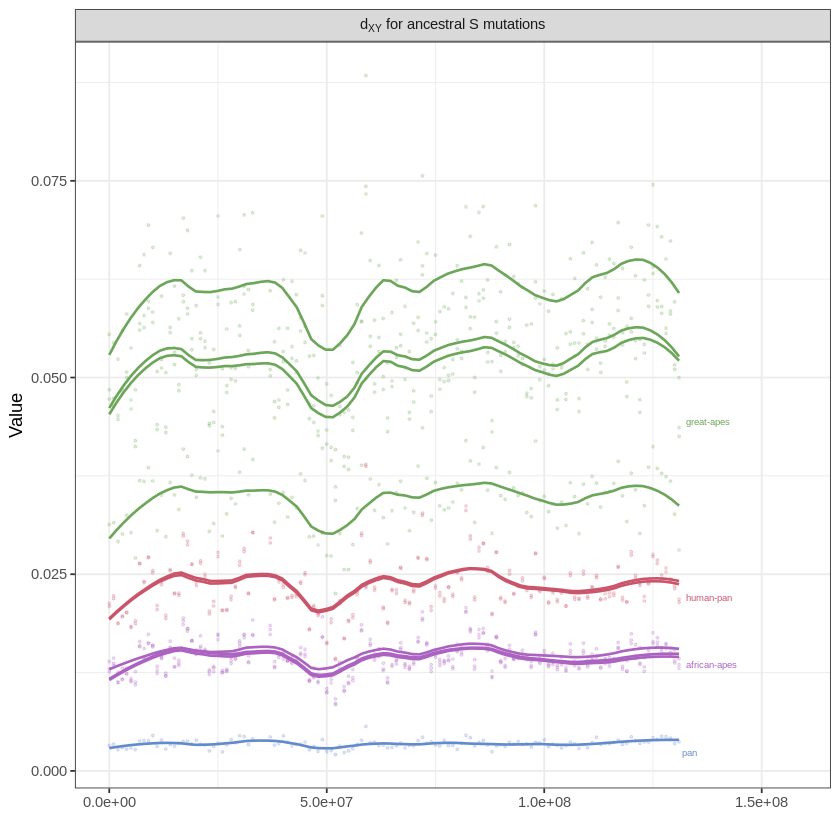

In [32]:
pidxy_path_gc = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_G-C_curr_all_prop-acc_0.4.tsv"

pidxy_gc = fread(pidxy_path_gc, header =T)

label = "d[XY]*' for ancestral S mutations'"
p_gc = plot_dxy_land(pidxy_gc, label)
p_gc

In [33]:
pdf(paste0(outpath,"anc-partitioned_dxy_landscapes_data.pdf"), width = 3.5, height = 6.0)
wrap_plots(p_at, p_gc, nrow=2) + plot_annotation(tag_levels = 'A')
#grid::grid.draw(grid::textGrob("Value", x = 0.05, rot = 90))
grid::grid.draw(grid::textGrob("Window", y = 0.04, x=0.58))
dev.off()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



png 
  2

In [34]:
rds_path = paste0(data_path,chrom,"/",f_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_WWSS_prop-acc_",prop_acc, ".rds")
df = readRDS(rds_path)
p1 = corr_dt_panel(df[df$stat1=="dxy" & df$stat2=="dxy",], end=0.3, dxydxylab="d[XY]-d[XY]*' for W-W or S-S mutations'") + labs( y="")

rds_path = paste0(data_path,chrom,"/",f_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_WS_prop-acc_",prop_acc, ".rds")
df = readRDS(rds_path)
p2 = corr_dt_panel(df[df$stat1=="dxy" & df$stat2=="dxy",], end=0.3,  dxydxylab="d[XY]-d[XY]*' for W-S mutations'")+ labs(y="")

In [35]:
pdf(paste0(outpath,"curr-partitioned-dxydxy-corr_data.pdf"), width = 6.5, height = 3.5)
(p1 + p2 & theme(legend.position = "none")) + plot_annotation(tag_levels = 'A')
grid::grid.draw(grid::textGrob("Correlation between landscapes", x = 0.03, rot = 90))
#grid::grid.draw(grid::textGrob("dT", y = 0.02, x=0.55))
dev.off()

png 
  2